In [1]:
## Here, we will use another method to find expectation values of the Hamiltonian

#IMporting libraries

###################    Step 1: Import all the libraries    ###########################


import qiskit
import sys
from qiskit.quantum_info import Statevector
from qiskit import QuantumCircuit
import qiskit_aer 
from qiskit.quantum_info import state_fidelity
from qiskit_aer import AerSimulator
#from qiskit import transpile
#from qiskit.quantum_info.states.random import random_statevector
#from qiskit.circuit.library import Initialize
#from qiskit.visualization import plot_bloch_multivector
import numpy as np
from qiskit.quantum_info import partial_trace # To check later whether our derived density matrix is correct
from qiskit.quantum_info import DensityMatrix
from qiskit.quantum_info import purity
from scipy import linalg as la


from qiskit_aer.primitives import Sampler
from qiskit_aer.primitives import Estimator
from qiskit.quantum_info import SparsePauliOp
from qiskit.quantum_info import Operator

from itertools import combinations, cycle #Used for fermi state
import math as m
import cmath as cm

from threading import Thread  ## For multithreading and paralell processing
import time

In [2]:
###################    Step 2: Define the helper functions    ###########################

N = 10  #Number of fermionic sites
theta = 1.07 #hoping parameter for free fermions
theta_k = 0.79 #Kondo interaction
max_trotter_steps = 5 #number of time steps
#time_corr = int(sys.argv[5]) #time for correlator functions

num_qubits = 2*N + 1  #In split side configuration

###################    Step 3: Define all the helper functions    ###########################

coeff_dict  = {}

def array_k1(num_qubits):  #assuming num_qubits is even
    array_k = []
    m = num_qubits/2
    if (m)%2!=0: #replace with m-1 for previous results
        for j in range(-int((m)//2),int((m)//2) + 1): #replace with m-1 for previous results
            array_k.append(2*np.pi*j/num_qubits)
    else:
        for j in range(-int((m)//2),int((m)//2)):
            array_k.append(2*np.pi*j/num_qubits)
    return array_k


def recursive_nested(l,num_qubits,coeff_array,coeff = 1,bitstr=''):

    m = int(num_qubits/2) # taking always even number of qubits

    #coeff_dict_2 = {}
    if l==m-1: # m-1, but we start with 0 indexing
        coeff_copy = coeff  #to ensure multiplied coeffs in previous rounds is preserved and reused
        bitstr_copy = bitstr
        for i in range(num_qubits):
            if str(i) in bitstr:
                pass
            else:
                coeff = coeff*coeff_array[l,i]
                bitstr = bitstr + f'{i}'
                bitstr_sorted = sort_bitstr(bitstr) #to sort the string first
                perm = perm_str2(bitstr,bitstr_sorted) # to compare hamming distance
                if bitstr_sorted in coeff_dict.keys():
                    coeff_dict[bitstr_sorted]+=coeff*perm
                else:
                    coeff_dict[bitstr_sorted] = coeff*perm
            bitstr = bitstr_copy
            coeff = coeff_copy
    if l!=m-1:
        coeff_copy = coeff  #to ensure multiplied coeffs in previous rounds is preserved and reused
        bitstr_copy = bitstr
        for i in range(num_qubits):
            if str(i) in bitstr:
                pass
            else:
                #print(coeff)
                coeff = coeff*coeff_array[l,i]
                bitstr += str(i)
                recursive_nested(l+1,num_qubits,coeff_array,coeff,bitstr)
            bitstr = bitstr_copy
            coeff = coeff_copy

    return coeff_dict

def sort_bitstr(bitstr):
    bit_array = []
    for i in bitstr:
        bit_array.append(i)
    #print(bit_array)
    bitstr_sorted = ''
    for i in range(len(bit_array)):
        bit_array[i] = int(bit_array[i])
    bit_array.sort()
    #print(bit_array)
    for i in bit_array:
        #print(i,str(i))
        bitstr_sorted += str(i)
        #print(bitstr_sorted)

    return bitstr_sorted

def perm_str2(cmpr,word):

   #  word = 'eyssaasse' base string
   # cmpr = 'seasysaes'  a string to find number of swaps from the base string
    swaps = 0

    # 1)
    chars = {c: [] for c in word}
    [chars[c].append(i) for i, c in enumerate(word)]
    for k in chars.keys():
        chars[k] = cycle(chars[k])

    # 2)
    idxs = [next(chars[c]) for c in cmpr]

    # 3)
    for cmb in combinations(idxs, 2):
        if cmb[0] > cmb[1]:
            swaps += 1

    #print(swaps)
    if swaps%2 == 0:
        return 1
    else:
        return -1
    
def fermi_state(num_qubits): #of the form num_qubits = 2*odd number. This function created the fermi state (FS)


    coeff_dict.clear()
    m = int(num_qubits/2)
    coeff_array = []
    array_k = array_k1(num_qubits)
    for k in array_k:
        pos_list = []
        for x in range(num_qubits):
            pos_list.append(np.exp(-1j*k*x))
        coeff_array.append(pos_list)

    coeff_array = np.array(coeff_array)

    #print(coeff_array)

    coeff_dict_2 = recursive_nested(0,num_qubits,coeff_array)
    #print(coeff_dict_2)
    bitstr_dict = {}
    for bstr in coeff_dict_2.keys():
        vac_str = ''
        num_list = []
        for k in range(m):
            num_list.append(int(bstr[k]))

        for i in range(num_qubits):
            if i in num_list:
                vac_str += '1'
            else:
                vac_str += '0'
        bitstr_dict[vac_str] = coeff_dict[bstr]

    #print(bitstr_dict)
    

    fermi_state = Statevector([0]*(2**num_qubits))

    for bstr in bitstr_dict.keys():
        fermi_state += Statevector.from_label(bstr)*bitstr_dict[bstr]

    val_array = []
    for i in bitstr_dict.values():
        val_array.append(i)
    np_array = np.array(val_array)
    #print(np_array)
    #print(np.linalg.norm(np_array))
    
    fermi_state = fermi_state/np.linalg.norm(val_array)
    #print(fermi_state)
    fermi_state.is_valid()

    return fermi_state

def fermi_state_circuit(N,num_cl_bits = 0):  #Initialize circuit with FS with both spin chains having it's own FS
    qc = QuantumCircuit(num_qubits,num_cl_bits)
    fermi_state_up = fermi_state(N)
    fermi_state_down = fermi_state(N)
    qc.initialize(fermi_state_up,range(N))
    qc.initialize(fermi_state_down,range(N+1,2*N+1))
    return qc

def fsim(theta,phi,beta):  #Block for free fermions
    fsim = Operator([[1,0,0,0],
                   [0,m.cos(theta),1j*cm.exp(1j*beta)*m.sin(theta),0],
                   [0,1j*cm.exp(-1j*beta)*m.sin(theta),m.cos(theta),0],
                   [0,0,0,cm.exp(1j*phi)]])
    return fsim

def add_fsim_half(qc,angles):
    theta = angles


    fsim1 = fsim(theta,0,0)
    fsim2 = fsim(2*theta,0,0)
    #Adding fsim in even layers
    for i in range(0,qc.num_qubits//2-1,2):
        qc.unitary(fsim1,[i,i+1],label = r'fsim$(\theta,\phi)$')

    for i in range(qc.num_qubits//2+1,qc.num_qubits-1,2):
        qc.unitary(fsim1,[i,i+1],label = r'fsim$(\theta,\phi)$')
        
    #Adding fsim in odd layers
    for i in range(1,qc.num_qubits//2-1,2):
        qc.unitary(fsim2,[i,i+1],label = r'fsim$(2\theta,\phi)$')

    for i in range(qc.num_qubits//2+2,qc.num_qubits-1,2):
        qc.unitary(fsim2,[i,i+1],label = r'fsim$(2\theta,\phi)$')

def add_fsim_inv_half(qc,angles):
    theta = angles


    fsim1 = fsim(theta,0,0)

        
    #Adding fsim in even layers
    for i in range(0,qc.num_qubits//2-1,2):
        qc.unitary(fsim1,[i,i+1],label = r'fsim$(\theta,\phi)$')

    for i in range(qc.num_qubits//2+1,qc.num_qubits-1,2):
        qc.unitary(fsim1,[i,i+1],label = r'fsim$(\theta,\phi)$')

def add_fsim_full(qc,angles):
    theta = angles


    fsim1 = fsim(theta,0,0)
    fsim2 = fsim(2*theta,0,0)
    #Adding fsim in even layers
    for i in range(0,qc.num_qubits//2-1,2):
        qc.unitary(fsim2,[i,i+1],label = r'fsim$(2\theta,\phi)$')

    for i in range(qc.num_qubits//2+1,qc.num_qubits-1,2):
        qc.unitary(fsim2,[i,i+1],label = r'fsim$(2\theta,\phi)$')
        
    #Adding fsim in odd layers
    for i in range(1,qc.num_qubits//2-1,2):
        qc.unitary(fsim2,[i,i+1],label = r'fsim$(2\theta,\phi)$')

    for i in range(qc.num_qubits//2+2,qc.num_qubits-1,2):
        qc.unitary(fsim2,[i,i+1],label = r'fsim$(2\theta,\phi)$')




    
def kondo_unitary(theta_k,theta_z):

    l1 = cm.exp(1j*theta_z/2)
    l2 = cm.exp(-1j*theta_z/2)
    c1 = m.cos(theta_k)
    s1 = m.sin(theta_k)

    a = m.cos(np.sqrt(2)*theta_k) - (1j/np.sqrt(2))*m.sin(np.sqrt(2)*theta_k)
    a_dag = m.cos(np.sqrt(2)*theta_k) + (1j/np.sqrt(2))*m.sin(np.sqrt(2)*theta_k)
    b = (-1j/np.sqrt(2))*m.sin(np.sqrt(2)*theta_k)
    c = cm.exp(-1j*theta_k) 
    d = cm.exp(1j*theta_k)

    """kondo_unitary = Operator([[1,0,0,0,0,0,0,0],
                          [0,1,0,0,0,0,0,0],
                          [0,0,l1,0,0,0,0,0],
                          [0,0,0,c1*l2,1j*l2*s1,0,0,0],
                          [0,0,0,1j*l2*s1,c1*l2,0,0,0],
                          [0,0,0,0,0,l1,0,0],
                          [0,0,0,0,0,0,1,0],
                          [0,0,0,0,0,0,0,1]])"""
    kondo_unitary = Operator([[1,0,0,0,0,0,0,0],
                          [0,a,0,0,0,0,b,0],
                          [0,0,1,0,0,0,0,0],
                          [0,0,0,d,0,0,0,0],
                          [0,0,0,0,c,0,0,0],
                          [0,0,0,0,0,1,0,0],
                          [0,b,0,0,0,0,a_dag,0],
                          [0,0,0,0,0,0,0,1]])
    
    kondo_unitary_2 = Operator([[1,0,0,0,0,0,0,0],
                          [0,1,0,0,0,0,0,0],
                          [0,0,c1*l1,0,0,1j*s1*l1,0,0],
                          [0,0,0,l2,0,0,0,0],
                          [0,0,0,0,l2,0,0,0],
                          [0,0,1j*s1*l1,0,0,c1*l1,0,0],
                          [0,0,0,0,0,0,1,0],
                          [0,0,0,0,0,0,0,1]])
    
    return kondo_unitary_2

def ts_state_circuit(N, num_cl_bits = 0):  #Initialize state with fixed number of paricles in up or down chain
    qc = QuantumCircuit(2*N+1,num_cl_bits)
    str1 = ''
    str2 = ''
    for i in range(N):
        if i%2 == 0:
            str1 += '1'
            str2 += '0'
        else:
            str1 += '0'
            str2 += '1'
    state = (Statevector.from_label(str1) + Statevector.from_label(str2))/np.sqrt(2)
    qc.initialize(state,range(N))
    qc.initialize(state,range(N+1,2*N+1))
    return qc

def circuit_3(N, trotter_steps,angles = 0,theta_k = 0,theta_z = 0, num_cl_bits = 0, trotter_barriers = False, save = False):
    if num_cl_bits == 0:
        qc = fermi_state_circuit(N)
    else:
        qc = fermi_state_circuit(N,num_cl_bits)
    qc.x(N)
    qc.barrier()
    
    c = num_qubits//2
    if trotter_steps == 0:
        if save == True:
            qc.save_statevector()
        return qc
    else:
        add_fsim_half(qc,angles)
        qc.unitary(kondo_unitary(theta_k,theta_z),[c,c+1,c-1],label=r'$U_{k}(\theta_k,\theta_z)$')
    
   
        if trotter_barriers:
                qc.barrier()
        for i in range(1,trotter_steps):
            add_fsim_full(qc,angles)
            qc.unitary(kondo_unitary(theta_k,theta_z),[c,c+1,c-1],label=r'$U_{k}(\theta_k,\theta_z)$')
        
            if trotter_barriers:
                qc.barrier()
        add_fsim_inv_half(qc,angles)
        if save == True:
            qc.save_statevector()
        #qc.save_statevector()  remove save for changing to operator
        return qc


    

H_t = 0
H_k = 0
for i in range(2*N):
    if i==N-1 or i==N:
        continue
    else:
        H_t += -theta*(SparsePauliOp('I'*(i) + 'XX' + 'I'*(2*N-i-1)) + SparsePauliOp('I'*(i) + 'YY' + 'I'*(2*N-i-1)))
H_k = (-theta_k/2)*(SparsePauliOp('I'*(N-1) + 'XXX' + 'I'*(N-1))+SparsePauliOp('I'*(N-1) + 'YXY' + 'I'*(N-1)) + SparsePauliOp('I'*(N-1) + 'XYY' + 'I'*(N-1))- SparsePauliOp('I'*(N-1) + 'YYX' + 'I'*(N-1))+ SparsePauliOp('I'*(N) + 'ZZ' + 'I'*(N-1)) - SparsePauliOp('I'*(N-1) + 'ZZ' + 'I'*(N)))
    
def plot_hexp(qc,index,h_values1):
    h_analytical = H_t + H_k
        #print("Operator obtained from circuit")
    job_analytical = estimator.run(qc,h_analytical,shots = None)
    h_list1.append((job_analytical.result().values[0],index))

    #print("Hamiltonian expectation calculated successfully!")

Creating state list....


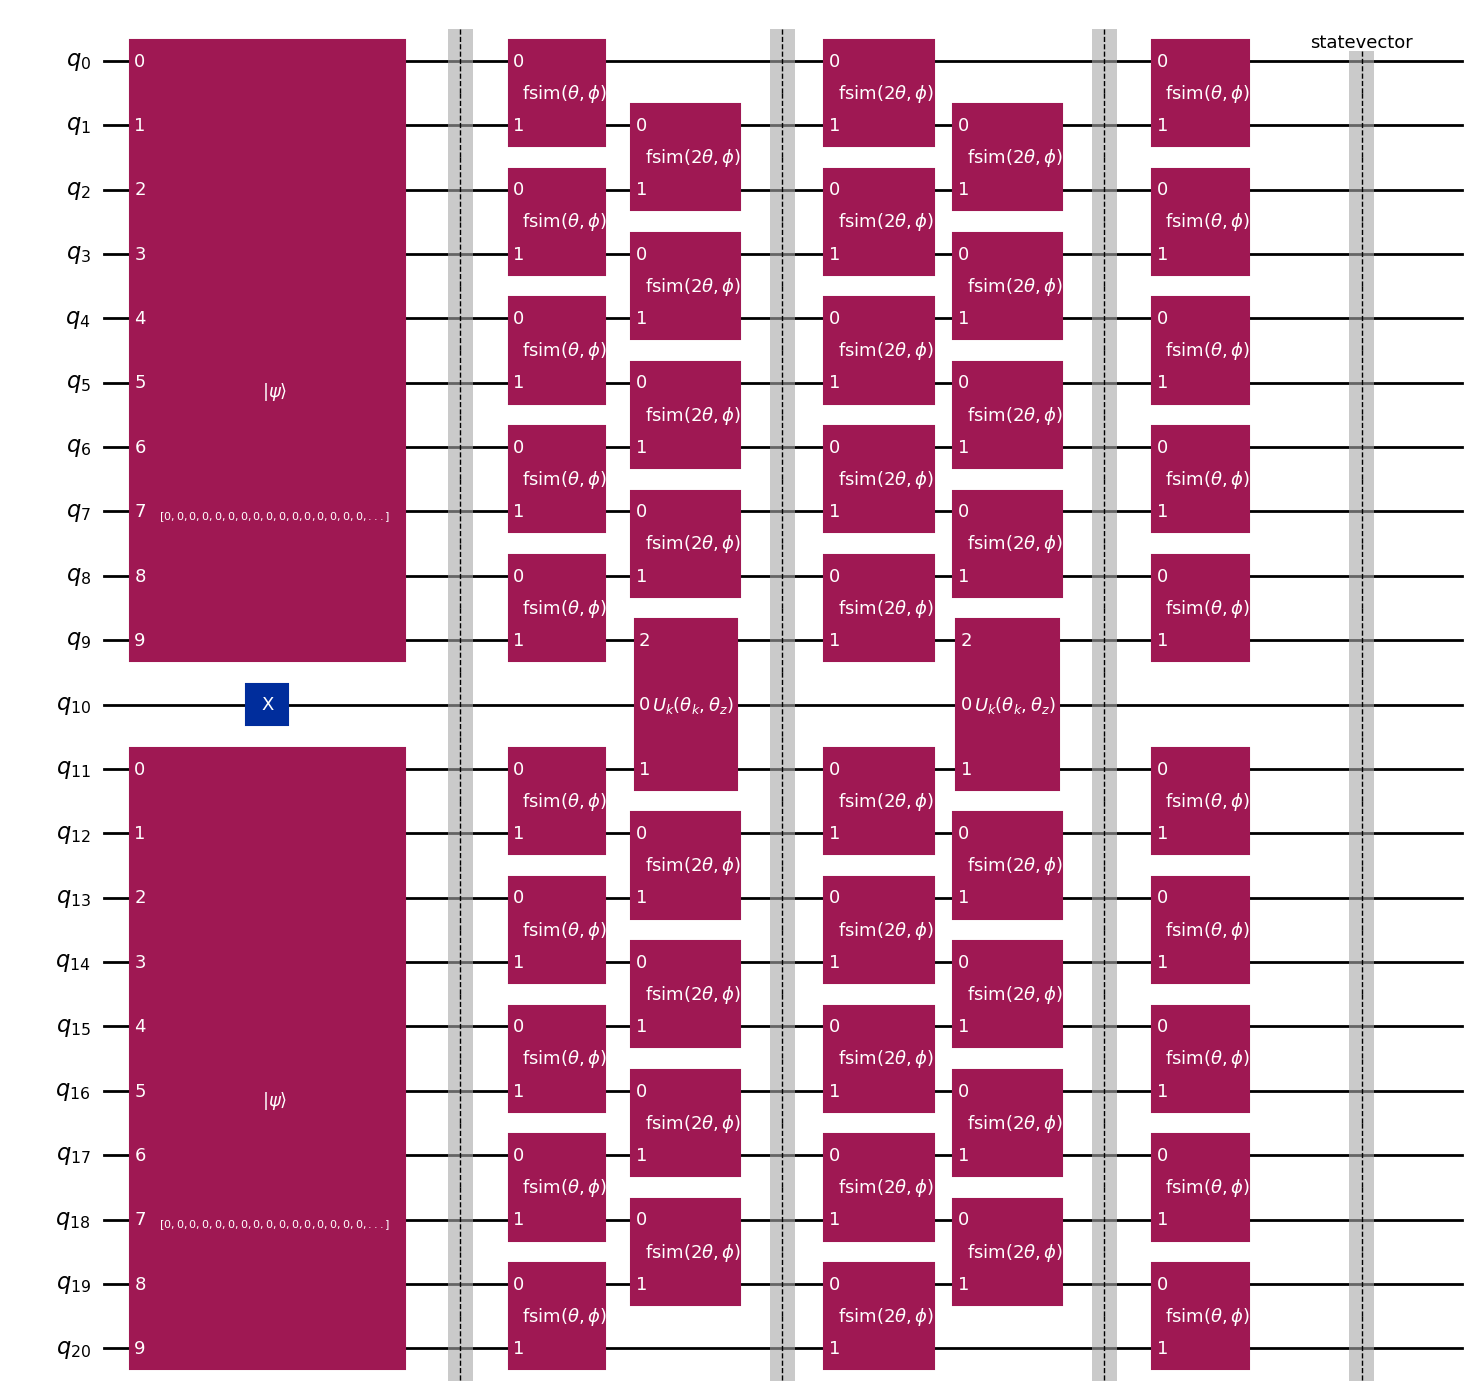

In [3]:
## Now, the strategy is to save the state_list after each trotter step and then conjugate with H to find the expectation vals

state_list1 = []
state_list2 = []


print('Creating state list....')
t0 = time.time()
theta_z = -theta_k
qc_list = [0]*max_trotter_steps
qc_list2 = [0]*max_trotter_steps

t0 = time.time()
theta_z = -theta_k
    
qc_list2[0] = circuit_3(N, 0, theta,theta_k,theta_z)
qc_list[0] = qc_list2[0].copy()
c = num_qubits//2
for t in range(1,max_trotter_steps):
    #print("Value of t:", t)
    qc = qc_list2[t-1].copy()
    if t == 1:
        add_fsim_half(qc,theta)
        qc.unitary(kondo_unitary(theta_k,theta_z),[c,c+1,c-1],label=r'$U_{k}(\theta_k,\theta_z)$')
    else:
        add_fsim_full(qc,theta)
        qc.unitary(kondo_unitary(theta_k,theta_z),[c,c+1,c-1],label=r'$U_{k}(\theta_k,\theta_z)$')
    qc.barrier()

                
                #qc.measure(measured_bits,list(range(len(measured_bits))))

    qc_list2[t] = qc.copy()
    add_fsim_inv_half(qc,theta)  
    qc_list[t] = qc.copy()
    del qc

qc_test = qc_list[2]
qc_test.save_statevector()
qc_test.draw(output = 'mpl')

In [4]:
qc_list_fin = []

for i in range(len(qc_list)):
    qc = qc_list[i].copy()
    qc.save_statevector(label = f'{i}')
    qc_list_fin.append(qc)

    del qc

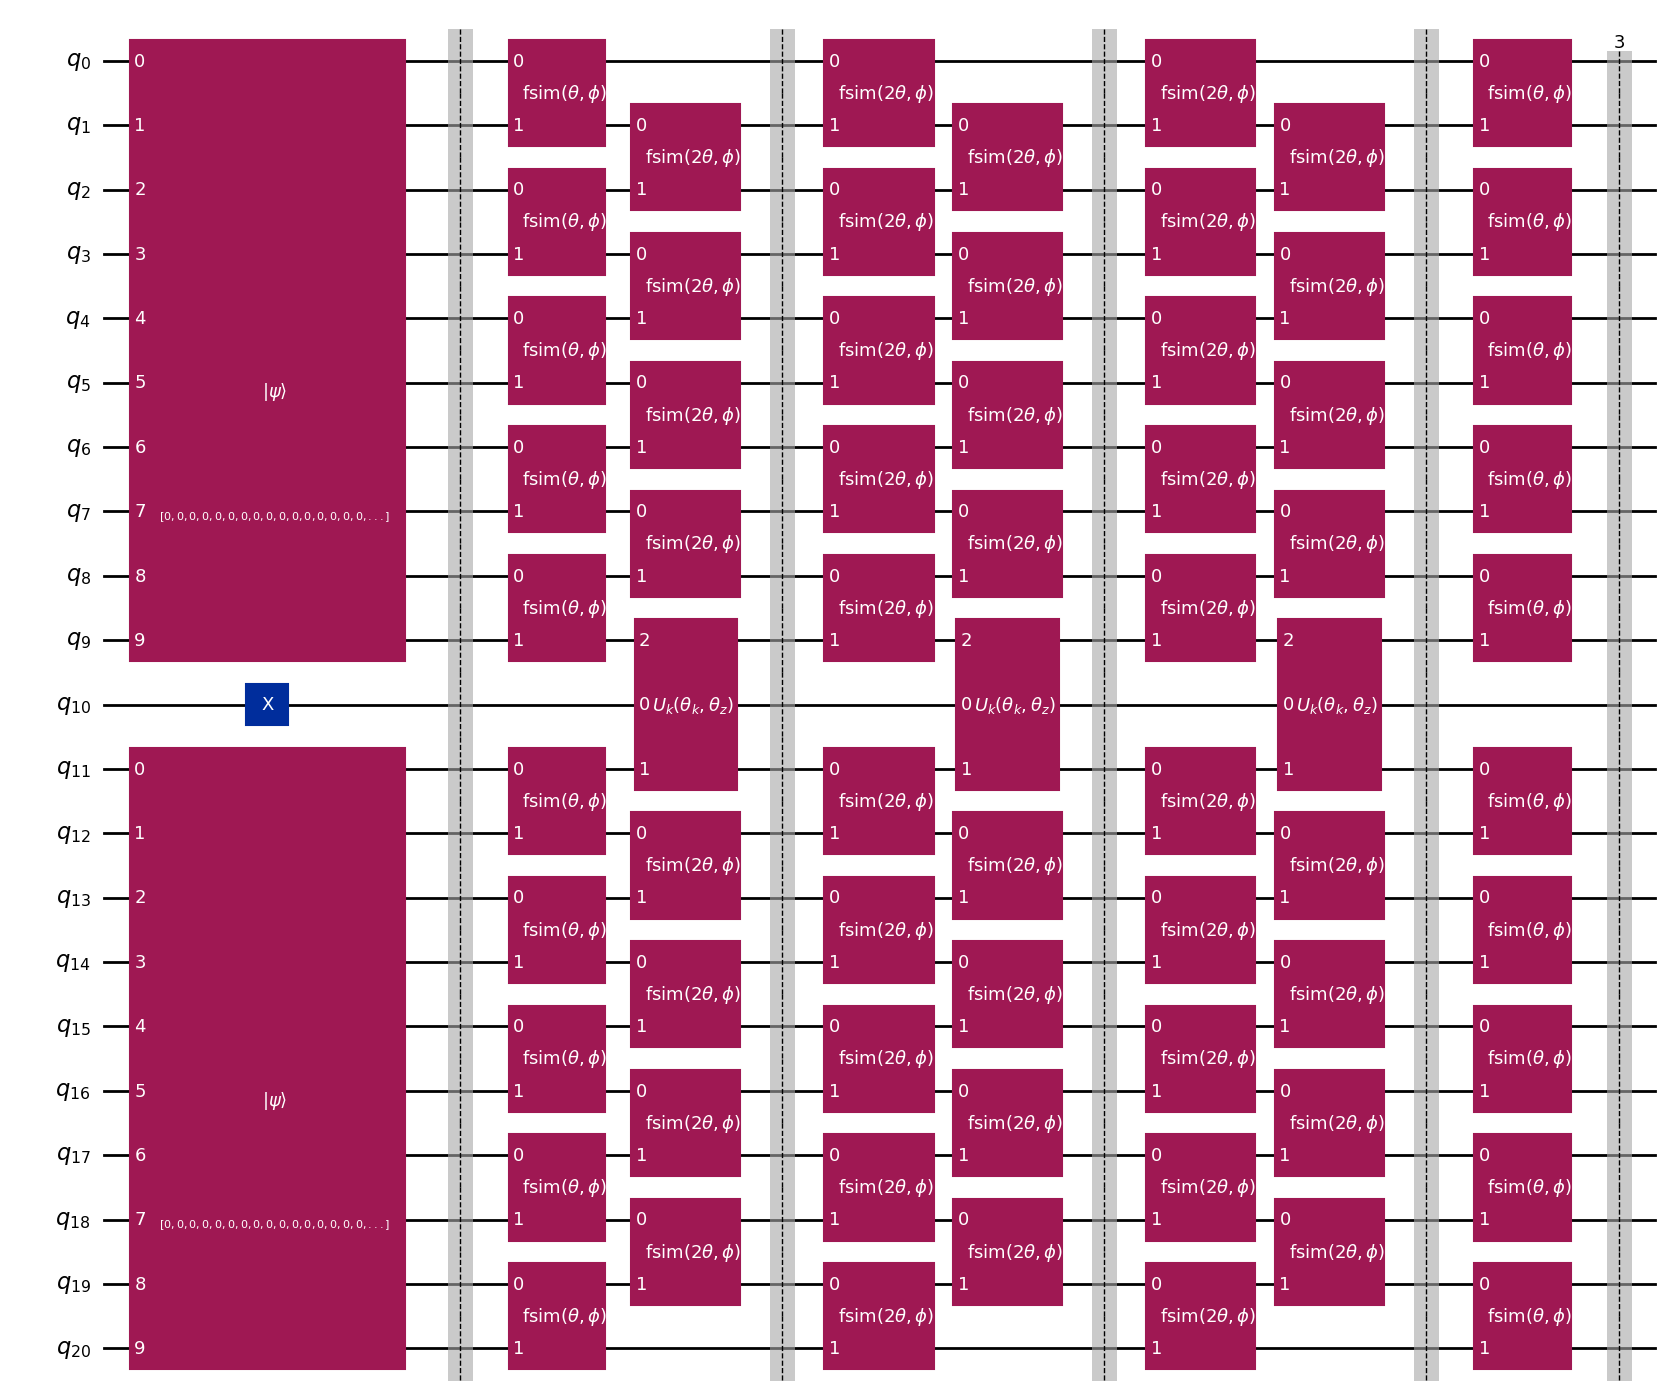

In [5]:
qc_list_fin[3].draw(output = 'mpl')

In [6]:
from qiskit import transpile

In [7]:
simulator_aer = [AerSimulator()]*max_trotter_steps

def state_list_comp(qc,index,state_list):
    qc_aer = transpile(qc, backend=simulator_aer[index])
    final_state = simulator_aer[index].run(qc_aer).result().data()[f'{index}']
    print("Final state computed for i =", index)
    state_list.append((final_state,index))


In [8]:
## Now, let us parallely compute the states for each circuit
t4 = time.time()
state_list = []
threads = [None]*max_trotter_steps

for i in range(max_trotter_steps):
    threads[i] = Thread(target = state_list_comp, args = (qc_list_fin[i],i,state_list))
    threads[i].start()

for i in range(len(threads)):
    threads[i].join()



    
t5 = time.time()
total3 = t5-t4

print("Multi-threading completed successfully! Time taken:",round(total3,2))

Final state computed for i = 0
Final state computed for i = 1
Final state computed for i = 4
Final state computed for i = 2
Final state computed for i = 3
Multi-threading completed successfully! Time taken: 379.65


In [9]:
print(state_list)

[(Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), 0), (Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), 1), (Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), 4), (Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), 2), (Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), 3)]


In [10]:
state_list.sort(key = lambda x: x[1])
state_list = [i[0] for i in state_list]

In [11]:
len(state_list)

5

In [13]:
H = H_k + H_t
print(H)

SparsePauliOp(['IIIIIIIIIXXXIIIIIIIII', 'IIIIIIIIIYXYIIIIIIIII', 'IIIIIIIIIXYYIIIIIIIII', 'IIIIIIIIIYYXIIIIIIIII', 'IIIIIIIIIIZZIIIIIIIII', 'IIIIIIIIIZZIIIIIIIIII', 'XXIIIIIIIIIIIIIIIIIII', 'YYIIIIIIIIIIIIIIIIIII', 'IXXIIIIIIIIIIIIIIIIII', 'IYYIIIIIIIIIIIIIIIIII', 'IIXXIIIIIIIIIIIIIIIII', 'IIYYIIIIIIIIIIIIIIIII', 'IIIXXIIIIIIIIIIIIIIII', 'IIIYYIIIIIIIIIIIIIIII', 'IIIIXXIIIIIIIIIIIIIII', 'IIIIYYIIIIIIIIIIIIIII', 'IIIIIXXIIIIIIIIIIIIII', 'IIIIIYYIIIIIIIIIIIIII', 'IIIIIIXXIIIIIIIIIIIII', 'IIIIIIYYIIIIIIIIIIIII', 'IIIIIIIXXIIIIIIIIIIII', 'IIIIIIIYYIIIIIIIIIIII', 'IIIIIIIIXXIIIIIIIIIII', 'IIIIIIIIYYIIIIIIIIIII', 'IIIIIIIIIIIXXIIIIIIII', 'IIIIIIIIIIIYYIIIIIIII', 'IIIIIIIIIIIIXXIIIIIII', 'IIIIIIIIIIIIYYIIIIIII', 'IIIIIIIIIIIIIXXIIIIII', 'IIIIIIIIIIIIIYYIIIIII', 'IIIIIIIIIIIIIIXXIIIII', 'IIIIIIIIIIIIIIYYIIIII', 'IIIIIIIIIIIIIIIXXIIII', 'IIIIIIIIIIIIIIIYYIIII', 'IIIIIIIIIIIIIIIIXXIII', 'IIIIIIIIIIIIIIIIYYIII', 'IIIIIIIIIIIIIIIIIXXII', 'IIIIIIIIIIIIIIIIIYYII', 'IIIIIIIIIIIIIIIIIIXXI', 'IIIIIIIII

In [17]:
state = state_list[0]
print(state)
print(state.conjugate() @ H @ state)

Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2))


TypeError: unsupported operand type(s) for @: 'Statevector' and 'SparsePauliOp'

In [ ]:
def expectation(state, operator):
    
    return state.conjugate()@operator@state